In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from toi5671 import Star

In [3]:
star = Star("TOI-5671")
star

Mstar=(0.40,0.02) Msun
Rstar=(0.41,0.01) Rsun
Rhostar=(5.89,0.62) rhosun
teff=(3380,157) K
logg=(4.82,0.00) cgs
feh=(0.00,0.10) dex


Star(name='TOI-5671', star_params=None, source='tic')

In [4]:
star.magnitudes

,band,value,value_e,mnotes,mdate,muser,mgroup,mtag,mtabname
0,TESS,14.8084,0.007451,TIC v8.2,2019-04-15,TESS project,,,tmag
1,V,16.2700,0.200000,TIC v8.2,2019-04-15,TESS project,,,vmag
2,Gaia,16.0461,0.000662,TIC v8.2,2019-04-15,TESS project,,,gaiamag
3,u,20.5820,0.048916,TIC v8.2,2019-04-15,TESS project,,,umag
4,g,18.0417,0.006337,TIC v8.2,2019-04-15,TESS project,,,gmag
5,r,16.5480,0.004716,TIC v8.2,2019-04-15,TESS project,,,rmag
6,i,15.3389,0.005026,TIC v8.2,2019-04-15,TESS project,,,imag
7,z,14.6238,0.005237,TIC v8.2,2019-04-15,TESS project,,,zmag
8,J,13.2470,0.028000,TIC v8.2,2019-04-15,TESS project,,,jmag
9,H,12.6590,0.023000,TIC v8.2,2019-04-15,TESS project,,,hmag


In [5]:
bands=['Gaia','V','J','H','K']
mags = {}
for band in bands:
    val=star.magnitudes.query("band==@band").value.squeeze()
    err=star.magnitudes.query("band==@band").value_e.squeeze()
    mags[band]=(val,err)
    print(band,val,err)

Gaia 16.0461 0.000662
V 16.27 0.2
J 13.247 0.028
H 12.659 0.023
K 12.362 0.023


In [6]:
star.get_gaia_sources()

Querying Gaia sources 30" around TOI-5671: (211.0092, 38.6183) deg.


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance
0,1635721458409799680,Gaia DR2 1485436090253564928,1485436090253564928,1473060304,2015.5,211.009220,0.029892,38.618331,0.037424,5.951009,...,0.163,0.4121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000015
1,1635721458409799680,Gaia DR2 1485436090253565056,1485436090253565056,510364955,2015.5,211.009596,0.020456,38.620245,0.025240,6.097446,...,0.179,0.4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.973067
2,1635721458409799680,Gaia DR2 1485436090253595008,1485436090253595008,1051443067,2015.5,211.006972,0.313153,38.624250,0.417065,0.924949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.227582


In [8]:
star.get_spectral_type(columns="Teff Bp-Rp J-H H-Ks W1-W2".split())

Loaded: ../data/Mamajek_table.csv
Gaia Teff=3589.81,637.0973304139347 K
Gaia=(16.0461,0.000662)
V=(16.27,0.2)
J=(13.247,0.028)
H=(12.659,0.023)
K=(12.362,0.023)
WISE 3.4 micron=(12.227,0.034)
WISE 4.6 micron=(12.112,0.034)
WISE 12 micron=(11.712,0.237)
Gaia Bp-Rp=2.60+/-0.01
J-H=0.59+/-0.05
H-Ks=0.30+/-0.05
W1-W2=0.12+/-0.07


'M5V'

## SED fit

In [9]:
import sys

sys.path.insert(1, "/ut3/muscat/src/AFPy")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, signal, optimize
import sed_fitting as sed
import LC_funcs as lc_func

import emcee
import corner
from multiprocessing import Pool

import os
os.environ['OMP_NUM_THREADS']='1'
os.nice(19)

19

In [11]:
wlmin=3000
wlmax=300000

wl_grid1 = np.arange(wlmin, wlmax, 0.1)
wl_grid2 = np.arange(wlmin, wlmax, 10)

t_grids = np.arange(2600,3600,100)
g_grids = np.array([4.0, 4.5, 5.0, 5.5])
m_grids = np.array([-0.5, 0.0, 0.3, 0.5])

nt = len(t_grids)
ng = len(g_grids)
nm = len(m_grids)

print(nt, ng, nm)

10 4 4


In [12]:
%%time

window = np.ones(100) / 100

spec_bin = {}
a=0

for i in range(nt):
    for j in range(ng):
        for k in range(nm):
            
            label = '{0:d}-{1:.1f}-{2:.1f}'.format(t_grids[i], g_grids[j], m_grids[k])
            wl, spec = sed.load_bt_settl(t_grids[i], g_grids[j], m_grids[k], a)
            # wl: Angstrom
            # spec: erg cm^-2 s^-1 A^-1
            
            ## smoothing and interpolating for 0.1 Angstrom grids
            spec_savgol = signal.savgol_filter(spec, 3, 1)
            spec_func1 = interpolate.interp1d(wl, spec_savgol, kind='linear')
            spec_interp1 = spec_func1(wl_grid1)

            ## averaging and interpolating for 10 Angstrom grids            
            spec_moveave = np.convolve(spec_interp1, window, mode='same')
            spec_func2 = interpolate.interp1d(wl_grid1, spec_moveave, kind='linear')
            spec_interp2 = spec_func2(wl_grid2)
            
            spec_bin[label] = spec_interp2

CPU times: user 26.8 s, sys: 1.41 s, total: 28.2 s
Wall time: 28.6 s


CPU times: user 22.2 ms, sys: 4.96 ms, total: 27.1 ms
Wall time: 39.1 ms


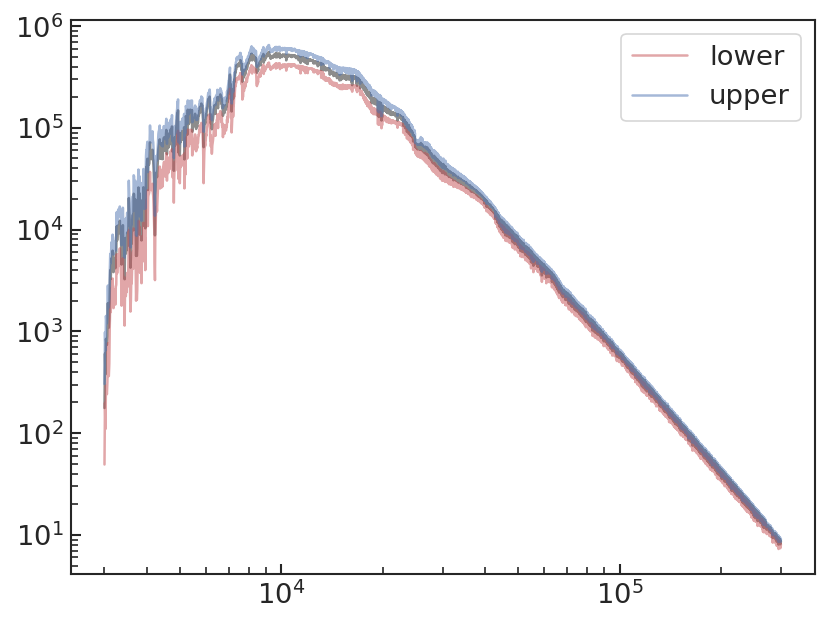

In [13]:
%%time

#from IRD
t = 3278 #+/- 124
g = 4.7
m = 0.31
flux_intp = sed.interp_spectra_3D(t,g,m, spec_bin)
plt.plot(wl_grid2, flux_intp, "k-", alpha=0.5)

# lower
t = 3100
g = 4.6
m = 0
flux_intp = sed.interp_spectra_3D(t,g,m, spec_bin)
plt.plot(wl_grid2, flux_intp, "r-", alpha=0.5, label="lower")

# upper
t = 3400
g = 4.8
m = 0.6
flux_intp = sed.interp_spectra_3D(t,g,m, spec_bin)
plt.plot(wl_grid2, flux_intp, "b-", alpha=0.5, label="upper")
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [14]:
magfile = '../data/magnitudes.csv'
band,mag,mage = np.genfromtxt(magfile, 
                              delimiter=',', 
                              skip_header=1, 
                              unpack=True, 
                              dtype=('<U4',float,float), 
                              usecols=(0,1,2))

mag_cat={}
mag_cat_err={}
mage_floor = 0.

for i in range(len(band)):
    mag_cat[band[i]] = mag[i]
    mag_cat_err[band[i]] = np.sqrt( mage[i]**2 + mage_floor**2 )

In [15]:
bands_cat = list(mag_cat.keys())
nband_cat = len(bands_cat)

trans=[]
zero_mag_flux=[]

flux_cat = np.zeros(nband_cat)
flux_cat_err = np.zeros(nband_cat)
wl_cen = np.zeros(nband_cat)

for i in range(nband_cat):
    if bands_cat[i]=='J' or bands_cat[i]=='H' or bands_cat[i]=='K':
        trans.append(sed.load_filter_response('2MASS', bands_cat[i], wl_grid2))
        zero_mag_flux.append(sed.zero_mag_flux('2MASS', bands_cat[i]))
        
    elif bands_cat[i]=='G' or bands_cat[i]=='BP' or bands_cat[i]=='RP':
        trans.append(sed.load_filter_response('Gaia', bands_cat[i], wl_grid2))
        zero_mag_flux.append(sed.zero_mag_flux('Gaia', bands_cat[i]))

    elif bands_cat[i]=='W1' or bands_cat[i]=='W2' or bands_cat[i]=='W3' or bands_cat[i]=='W4':
        trans.append(sed.load_filter_response('WISE', bands_cat[i], wl_grid2))
        zero_mag_flux.append(sed.zero_mag_flux('WISE', bands_cat[i]))

    flux_cat[i] = 10**(-0.4*mag_cat[bands_cat[i]]) * zero_mag_flux[i]
    flux_cat_err[i] = 0.4*np.log(10)*flux_cat[i]*mag_cat_err[bands_cat[i]]
    wl_cen[i] = np.sum(trans[i]*wl_grid2)/np.sum(trans[i])
    print(i, wl_cen[i], flux_cat[i], flux_cat_err[i])

0 6390.235967314677 9.880302708545262e-16 2.5480266258680815e-18
1 5182.576221055991 4.339083247456883e-16 2.3023510203537706e-18
2 7825.080506091992 1.4908628692481353e-15 5.548840342828777e-18
3 12412.960507539668 1.5725539837629118e-15 4.055452084253787e-17
4 16513.59127770306 9.786556548175633e-16 2.0731628882006677e-17
5 21655.55531016508 4.863490528047008e-16 1.0302712726614877e-17
6 33791.91321898688 1.051681606344895e-16 3.293357489510271e-18
7 46292.96614728299 3.452368418189438e-17 1.081114599513515e-18


In [16]:
Rsun = 6.96e8 # km
pc = 3.085677581e16 # m
GMsun = 1.32712440041e20 # m^3 s^-2

def log_like(p):
    
    t, rs, ms, m, d, log_jit = p
    
#    m = m_prior + np.random.randn(1)*m_prior_err
#    ms = ms_prior + np.random.randn(1)*ms_prior_err
    
    if t <= 2600 or t >= 3500:
        return -np.inf

    if m <= -0.5 or m >= 0.5:
        return -np.inf
    
    if rs <= 0 or d <= 0 or ms <= 0:
        return -np.inf
    
    if log_jit < -10 or log_jit > 10:
        return -np.inf
    
    logg = np.log10( GMsun*ms / (rs*Rsun)**2 *100 ) # cgs
    theta = rs*Rsun/(d*pc)
    pi = 1e3/d # mas

    if logg <= 4.0 or logg >= 5.5:
        return -np.inf

    jit = np.exp(log_jit)
    
    flux_intp = sed.interp_spectra_3D(t, logg, m, spec_bin)
    
    log_like = 0
    for i in range(nband_cat):
        
        flux_model = theta**2 *\
            np.sum(wl_grid2*flux_intp*trans[i])/np.sum(wl_grid2*trans[i])

        flux_cat_err2 = (0.4*np.log(10)*flux_cat[i])**2\
                            *(mag_cat_err[bands_cat[i]]**2 +jit**2)
        
        log_like += -0.5*(flux_cat[i] -flux_model)**2 / flux_cat_err2\
                    -0.5*np.log(2*np.pi*flux_cat_err2)
        
    log_like += -0.5*(t - t_prior)**2/t_prior_err**2
    log_like += -0.5*(m - m_prior)**2/m_prior_err**2
    log_like += -0.5*(ms - ms_prior)**2/ms_prior_err**2
    log_like += -0.5*(rs - rs_prior)**2/rs_prior_err**2
    log_like += -0.5*(pi - pi_prior)**2/pi_prior_err**2
        
    return log_like

In [17]:
def neg_log_like(p):
    return -log_like(p)

In [27]:
p0 = [3300, 0.4, 0.4, 0.3, 6, -5]
print(len(p0))

## PRIORS for TOI-5671

## from IRD 
m_prior = 0.31
m_prior_err = 0.33

## from emp. relations (no Fe/H prior)
# ms_prior = 0.3956 
# ms_prior_err = 0.0089 * 5
# rs_prior = 0.4036 
# rs_prior_err = 0.0122 * 5


## from emp. relations with Fe/H prior
# Ms (w/ [Fe/H]) = 0.3909 +/- 0.0092
# Rs (w/ [Fe/H]) = 0.4089 +/- 0.0131

ms_prior = 0.3909
ms_prior_err = 0.0092 * 5
rs_prior = 0.4089
rs_prior_err = 0.0131 * 5

## from IRD
t_prior = 3278
t_prior_err = 124

## from GaiaDR3
pi_prior = 6.0742
pi_prior_err = 0.0348

res = optimize.minimize(neg_log_like, p0, method='Nelder-Mead')

for i in range(5):
    res = optimize.minimize(neg_log_like, res.x, method='Nelder-Mead')
print(res)

6
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -297.6120300964384
             x: [ 3.355e+03  4.163e-01  3.962e-01  2.785e-01  1.646e+02
                 -3.343e+00]
           nit: 207
          nfev: 331
 final_simplex: (array([[ 3.355e+03,  4.163e-01, ...,  1.646e+02,
                        -3.343e+00],
                       [ 3.355e+03,  4.163e-01, ...,  1.646e+02,
                        -3.343e+00],
                       ...,
                       [ 3.355e+03,  4.163e-01, ...,  1.646e+02,
                        -3.343e+00],
                       [ 3.355e+03,  4.163e-01, ...,  1.646e+02,
                        -3.343e+00]]), array([-2.976e+02, -2.976e+02, -2.976e+02, -2.976e+02,
                       -2.976e+02, -2.976e+02, -2.976e+02]))


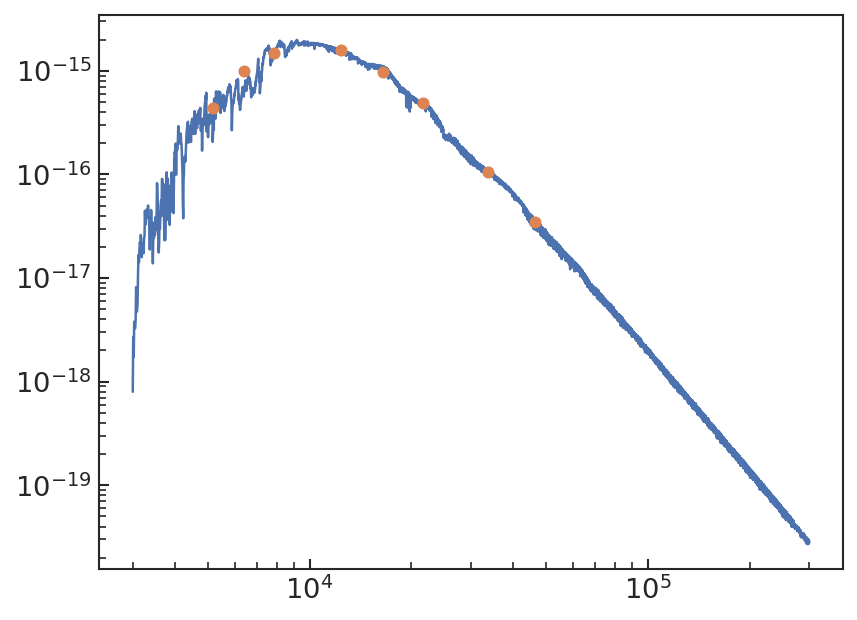

In [28]:
t, rs, ms, m, d, log_jit = res.x
        
# ms = ms_prior
# m = m_prior
logg = np.log10( GMsun*ms / (rs*Rsun)**2 *100 ) # cgs
theta = rs*Rsun/(d*pc)
pi = 1e3/d # mas

jit = np.exp(log_jit)

spec = sed.interp_spectra_3D(t, logg, m, spec_bin)

flux_cat_err=np.zeros(nband_cat)
for i in range(nband_cat):
    flux_cat_err[i] = 0.4*np.log(10)*flux_cat[i]\
                    *np.sqrt((mag_cat_err[bands_cat[i]]**2 +jit**2)) 

plt.plot(wl_grid2, spec*theta**2)
plt.errorbar(wl_cen, flux_cat, yerr=np.sqrt(flux_cat_err**2), fmt='o')
plt.xscale('log')
plt.yscale('log')

In [29]:
Lsun = 3.839e33 # erg/s
Rsun = 6.96e8 # m
#Rsun = 696000*1e2 # cm
Ltot = np.sum(10*spec) * 4*np.pi*(rs*Rsun*1e2)**2

Ltot/Lsun

0.019626161758665415

In [30]:
%%time

ndim, nwalkers = len(p0), 30
pos = [res.x + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

nsteps = 5_000

filename = 'mcmc_fit_sed_TOI-5671.hd5'
!rm -f $filename
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like,\
                backend=backend, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:23<00:00, 34.75it/s]

CPU times: user 1min 5s, sys: 10.9 s, total: 1min 16s
Wall time: 2min 24s


In [31]:
samples = sampler.get_chain()
pos = samples[-1,:,:]

nsteps = 5_000

filename = 'mcmc_fit_sed_TOI-5671.hd5'
!rm -f $filename
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like,\
                backend=backend, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:27<00:00, 33.79it/s]


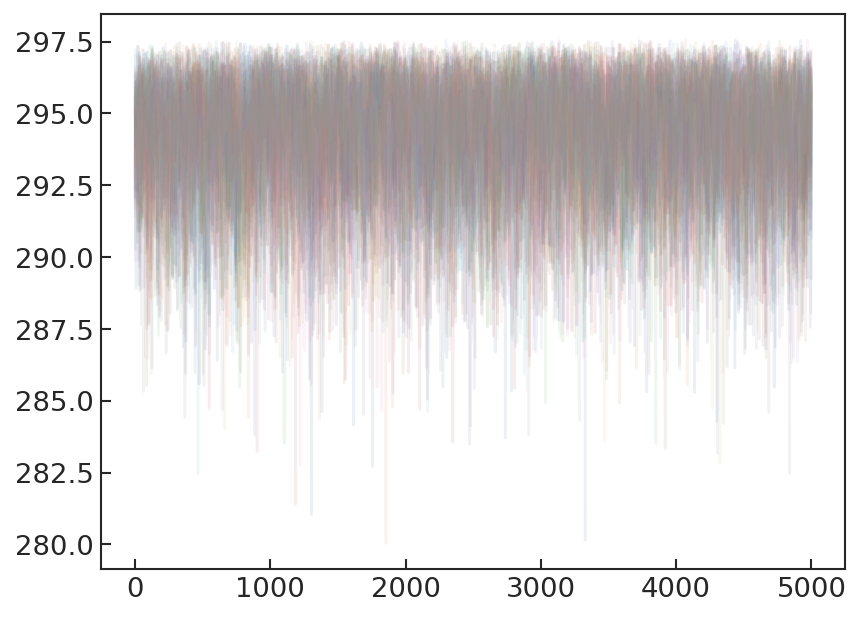

In [32]:
log_prob = sampler.get_log_prob()
for i in range(nwalkers):
    plt.plot(log_prob[:,i],alpha=0.1)

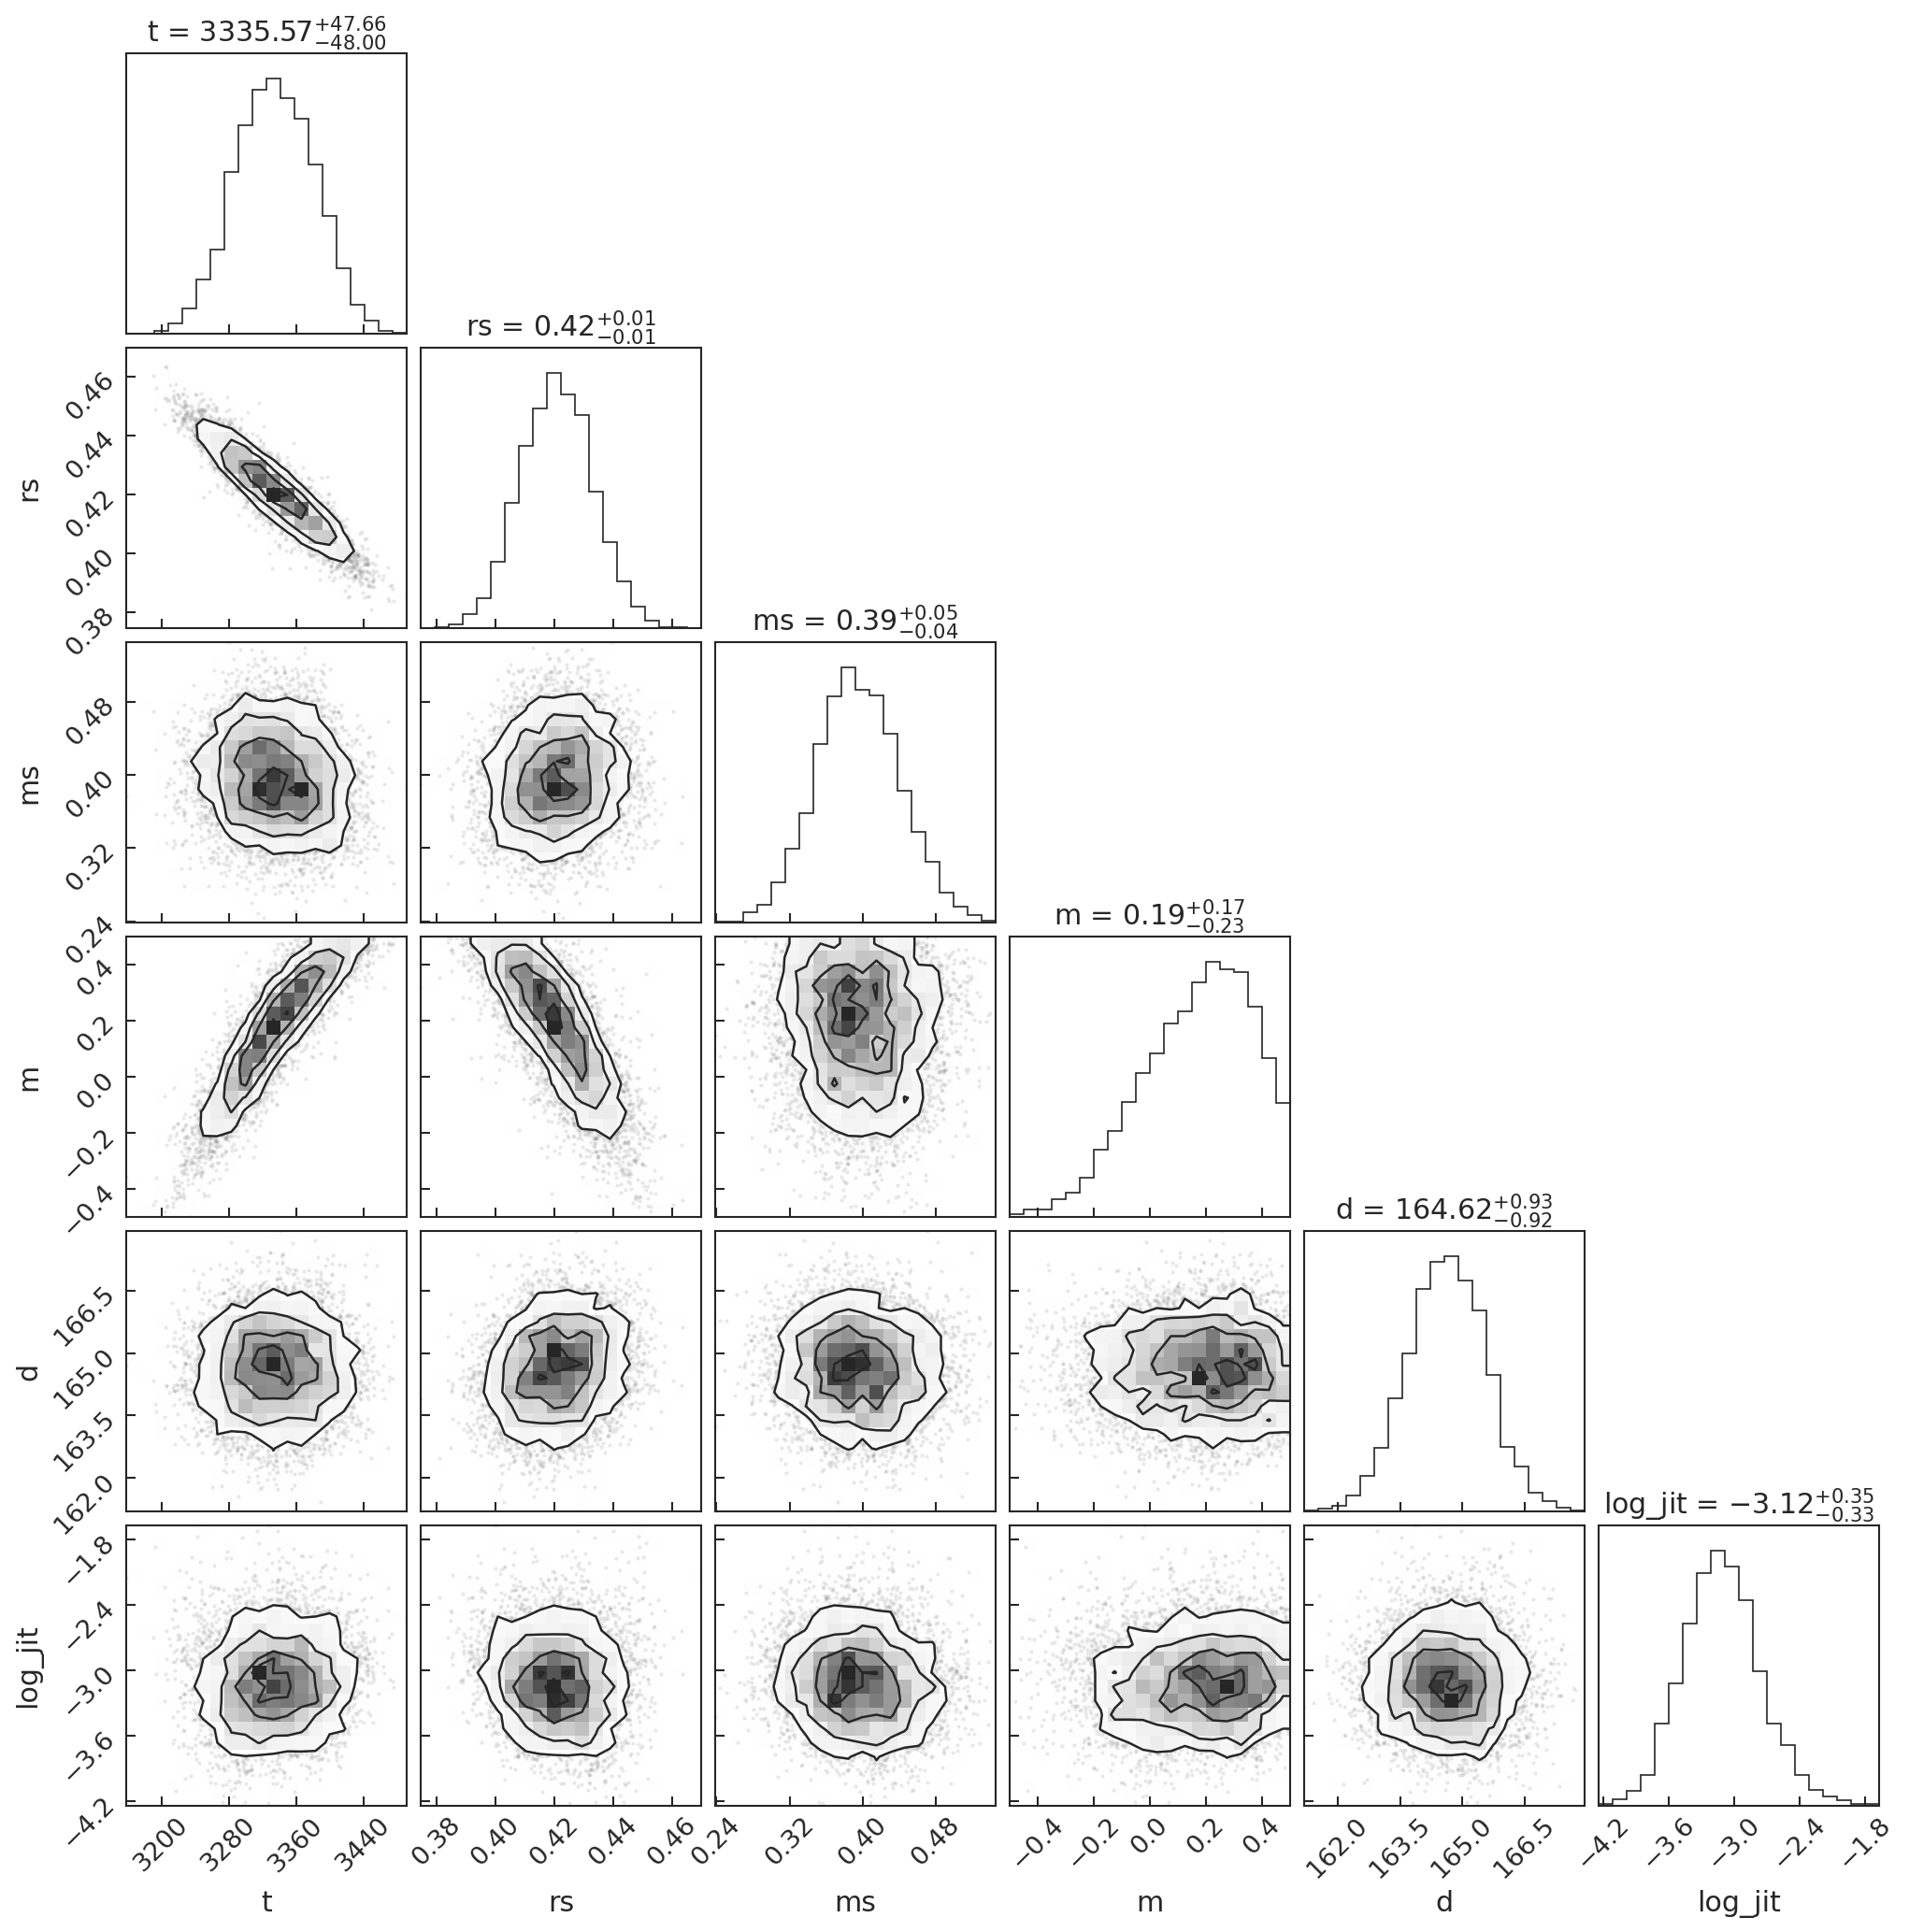

In [33]:
n0=3_000
log_prob = sampler.get_log_prob(flat=True, discard=n0, thin=10)
samples = sampler.get_chain(flat=True, discard=n0, thin=10)

mask = (log_prob > 0)
#& (samples[:,10] > 0.001)
    
plt.rcParams['font.size']=16

fig = corner.corner(samples[:,:][mask],
                    labels=['t', 'rs', 'ms', 'm', 'd', 'log_jit'],
                    show_titles=True
                   )

In [34]:
# for BHAC15
sig_B = 5.670374419e-8 # W m^-2 K^-4
Lsun = 3.839e26 # W
Tsun = (Lsun/(4*np.pi*sig_B*Rsun**2))**0.25
#print(Tsun)
Msun = 1.9891e33 # g


Teff = samples[:,0]
Rs = samples[:,1]
Ms = samples[:,2]
feh = samples[:,3]
d = samples[:,4]
log_jit = samples[:,5]
jit = np.exp(log_jit)


Ms = ms_prior + np.random.randn(len(Rs))*ms_prior_err
logg = np.log10( GMsun*Ms / (Rs*Rsun)**2 *100 ) # cgs

val = lc_func.percentile(jit)
print('jit = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))


val = lc_func.percentile(Teff)
print('Teff = ${0:.0f}\ ^{{+{1:.0f}}}_{{-{2:.0f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(feh)
print('[Fe/H] = ${0:.3f}\ ^{{+{1:.3f}}}_{{-{2:.3f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(Rs)
print('Rs = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(Ms)
print('Ms = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(d)
print('d = ${0:.4f}\ ^{{+{1:.4f}}}_{{-{2:.4f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

val = lc_func.percentile(logg)
print('logg = ${0:.3f}\ ^{{+{1:.3f}}}_{{-{2:.3f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

rhos = (Ms*Msun)/(4/3*np.pi*(Rs*Rsun*1e2)**3) # g cm^-3
val = lc_func.percentile(rhos)
print('rhos (g cm^-3) = ${0:.1f}\ ^{{+{1:.1f}}}_{{-{2:.1f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

rhos = Ms/(Rs**3) # rho_sun
val = lc_func.percentile(rhos)
print('rhos (rho_sun) = ${0:.2f}\ ^{{+{1:.2f}}}_{{-{2:.2f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))



logL = 2*np.log(Rs) + 4*(np.log(Teff)-np.log(Tsun))
L = np.exp(logL)
val = lc_func.percentile(L)
print('L (Lsun) = ${0:.5f}\ ^{{+{1:.5f}}}_{{-{2:.5f}}}$'.format(val[0], val[2]-val[0], val[0]-val[1]))

jit = $0.0442\ ^{+0.0187}_{-0.0126}$
Teff = $3336\ ^{+48}_{-48}$
[Fe/H] = $0.193\ ^{+0.176}_{-0.231}$
Rs = $0.4210\ ^{+0.0120}_{-0.0122}$
Ms = $0.3906\ ^{+0.0479}_{-0.0459}$
d = $164.6186\ ^{+0.9345}_{-0.9288}$
logg = $4.780\ ^{+0.056}_{-0.058}$
rhos (g cm^-3) = $7.4\ ^{+1.2}_{-1.0}$
rhos (rho_sun) = $5.22\ ^{+0.82}_{-0.70}$
L (Lsun) = $0.01970\ ^{+0.00041}_{-0.00044}$
